In [1]:
import powerlawrs 
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = "../reference_data/blackouts.txt"

# polars and pandas do NOT do a good job detecting headers, do not rely on them.
df = pl.read_csv(file, has_header=False)
data = df.to_series() #to_series() will work as well

# 1. Quickstart: Fit Pareto Type I
Goal: Parameter estimation

In [3]:
p = powerlawrs.fit(data)

In [4]:
# model parameters are stored in the ParetoFit object
p.ParetoFit

ParetoFit(x_min=230000, alpha=1.2726372198302858, D=0.06067379629443781, len_tail=59)

## Plot The data and model

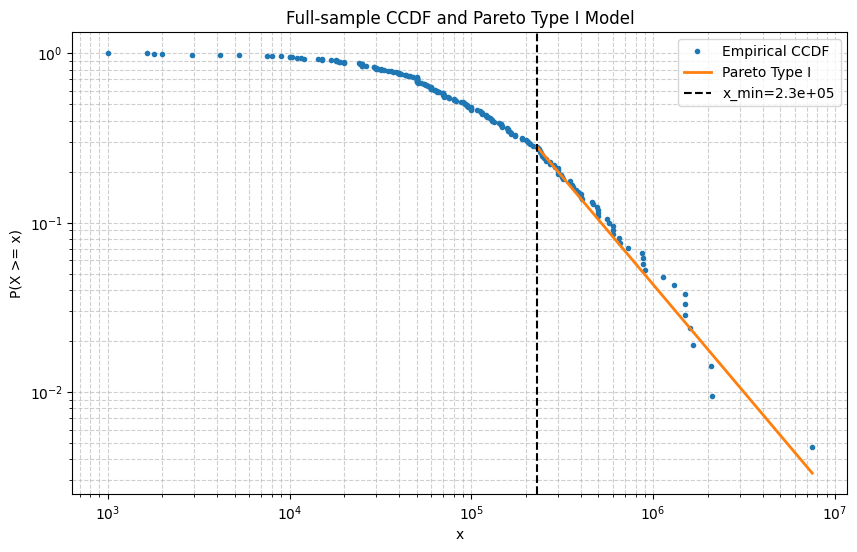

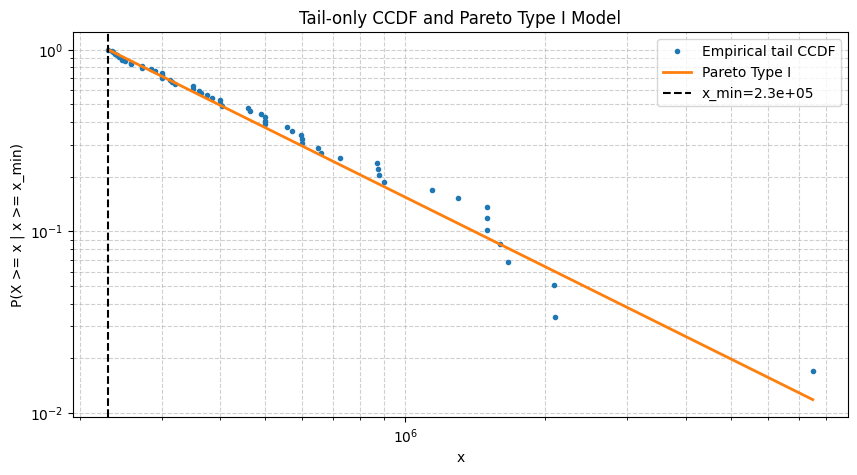

In [5]:
p.plot()

## Explore $x_{min}$ and $\alpha$ relationships
The following will demonstrate the methodology proposed by Clauset, Aaron, et al. ‘Power-Law Distributions in Empirical Data’. SIAM Review, vol. 51, no. 4, Society for Industrial & Applied Mathematics (SIAM), Nov. 2009, pp. 661–703, [doi:10.48550/ARXIV.0706.1062](https://doi.org/10.48550/arXiv.0706.1062).

In [6]:
# 1. MLE estimates of alpha for each x_min of the data have already been calculated during the fit() proceedure. 
pl.DataFrame(data={'x_min': p.x_mins, "alpha": p.alphas}).head(5)

x_min,alpha
f64,f64
1000.0,0.220177
1646.0,0.245997
1800.0,0.250307
2000.0,0.255823
2900.0,0.281194


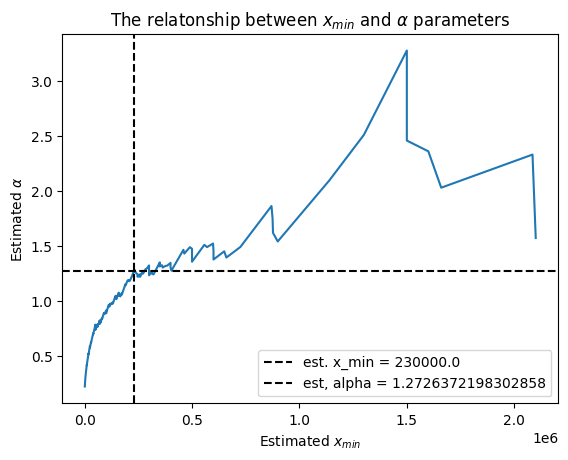

In [7]:
# 2. Plot alpha conditioned on x_min.
# See Figure 3.3 Clauset et al. [doi:10.48550/ARXIV.0706.1062](https://doi.org/10.48550/arXiv.0706.1062)
plt.plot(p.x_mins, p.alphas)
# Identify where the estimate parameters are.
plt.axvline(x = p.ParetoFit.x_min, color = 'black', linestyle = '--', label = f"est. x_min = {p.ParetoFit.x_min}")
plt.axhline(y = p.ParetoFit.alpha, color = 'black', linestyle = '--', label = f"est, alpha = {p.ParetoFit.alpha}")
plt.xlabel(r"Estimated $x_{min}$")
plt.ylabel(r"Estimated $\alpha$")
plt.title(r"The relatonship between $x_{min}$ and $\alpha$ parameters")
plt.legend()
plt.plot;

# 2. Alternative Distributions 
**Pupose:** Fit various fat tailed distributions to the same tail as identified during the best fit proceeedure for the Pareto Type I. We are working towards comparing all of them to identify which model is most likely given the data.
## Fit Shifted Exponential 
Quickly fit an Exponential distribution conditonal on the Pareto Type I $x_{min}$ via ```<Distribution Name>.from_fitment()```

In [8]:
expo = powerlawrs.exponential.Exponential.from_fitment(data, p.ParetoFit)

In [9]:
print(f"{expo.name()}: {expo.parameters()}")

Exponential: [('lambda', 2.031590264467944e-06), ('x_min', 230000.0)]


## Fit Pareto Type I  
We already did this via ```gof()``` but more instances can be instantiated easily, with the same parameters for api consistency.

In [10]:
another_p = powerlawrs.pareto.Pareto.from_fitment(p.ParetoFit)

In [11]:
print(f"{another_p.name()}: {another_p.parameters()}")

Pareto: [('alpha', 1.2726372198302858), ('x_min', 230000.0)]


## Fit truncated Lognormal
Quickly fit an truncated Lognormal distribution conditonal on the Pareto Type I $x_{min}$ via ```<Distribution Name>.from_fitment()```

In [14]:
log_n = powerlawrs.lognormal.Lognormal.from_fitment(data, p.ParetoFit)

In [17]:
print(f"{log_n.name()}: {log_n.parameters()}")

Lognormal: [('mu', 7.049388195017023), ('sigma', 2.3019152092024213), ('x_min', 230000.0)]


# 3. Model Selection
## Vuongs closenes test

In [ ]:
# isolate the tail
tail = data.filter(data >= another_p.x_min).to_numpy()

# calculate the log likelihoods for each element given a distribution
dist1 = another_p.loglikelihood(tail)
dist2 = expo.loglikelihood(tail)

In [ ]:
Z, p_value = powerlawrs.stats.compare.vuongs_test(dist1, dist2)
print(f"Z score: {Z}, p_value: {p_value}")